<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [0]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_idx = [vgg_names.index('conv4_2')]
style_idx = [vgg_names.index('conv1_1'), vgg_names.index('conv2_1'), vgg_names.index('conv3_1'), vgg_names.index('conv4_1'), vgg_names.index('conv5_1')]


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**
* Display the style tensor and content tensor transformed back to an image


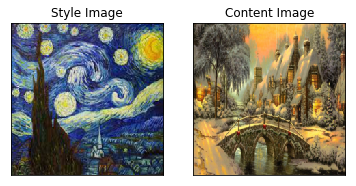

In [33]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
  image = tensor.cpu().clone()  
  image = image.squeeze(0)    
  image = toPIL(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if title is not None:
    plt.title(title)

plt.figure(1)     
plt.subplot(121)
display(style_image, title='Style Image')

plt.subplot(122)
display(content_image, title='Content Image')

plt.show()

___

### Part 3
Create a classes for the style and content loss

**TODO:**

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [34]:
def gram_matrix(activation):
  b,c,h,w = activation.shape # batch, channels, height, width
  features = activation.view(b*c, h*w) # reshape (flatten image)
  basis = features @ features.t() # ortho-normal basis
  gram = basis / (b*c*h*w) # normalize
  return gram
  
class ContentLoss(nn.Module):
  def __init__(self, idxs, image):
    super(ContentLoss, self).__init__()
    self.vgg = VGGIntermediate(idxs).cuda()
    activations = self.vgg(image)
    self.P = []
    for key in activations.keys():
      self.P.append(activations[key].detach())
    
  def forward(self, x):
    activations = self.vgg(x)
    loss = 0
    for l, key in enumerate(activations.keys()):
      Fl = activations[key]
#       loss += F.mse_loss(Fl, self.P[l])
      loss += torch.sum((Fl-self.P[l])**2) / Fl.size().numel()
    loss *= 0.5
    return loss
    
class StyleLoss(nn.Module):
  def __init__(self, idxs, image):
    super(StyleLoss, self).__init__()
    self.vgg = VGGIntermediate(idxs).cuda()
    activations = self.vgg(image)
    self.grams = []
#     self.weights = []
    for key in activations.keys():
      Fl = activations[key].detach()
      self.grams.append(gram_matrix(Fl))
#       b,c,h,w = Fl.shape
#       self.weights.append( 1 / (4 * (c*h*w)**2 * len(activations)) )
    
  def forward(self, x):
    activations = self.vgg(x)
    loss = 0
    for l, key in enumerate(activations.keys()):
      G = gram_matrix(activations[key])
      loss += F.mse_loss(G, self.grams[l]) / len(activations)
#       loss += self.weights[l] * torch.sum((self.grams[l]-G)**2)
    return loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_obj = ContentLoss(content_idx, content_image)

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_obj = StyleLoss(style_idx, style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**
* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!



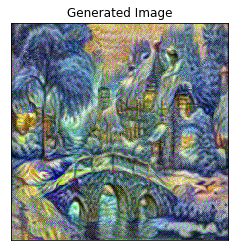

In [37]:
# Start with a copy of the content image
gen_image = content_image.clone()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
optimizer = optim.Adam([gen_image.requires_grad_()], lr=0.1)

losses = []

alpha = 1.0
beta = 10000.0
num_epochs = 500
loop_rate = 50
loop = tqdm(total=num_epochs//loop_rate+1,position=0,leave=False)
for epoch in range(num_epochs):
  optimizer.zero_grad()
  
  content_loss = content_obj(gen_image) * alpha
  style_loss = style_obj(gen_image) * beta
  loss = style_loss + content_loss
  if epoch % loop_rate == 0:
    losses.append(loss.item())
    msg = 'e:{}, sl:{:.4f}, cl:{:.4f}'
    msg = msg.format(epoch, style_loss.item(), content_loss.item())
    loop.set_description(msg)
    loop.update(1)
  
  loss.backward()
  optimizer.step()
  
  gen_image.data.clamp_(0,1) # normalize image
  
loop.close()
  
# Show the image
plt.figure(2)
display(gen_image, title='Generated Image')


### Part 5

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Eq 1: $\mathcal{L}_{content}(\vec{p},\vec{x},l) = \frac{1}{2}\sum\limits_{ij} \left( F_{ij}^l-P_{ij}^l \right)$

$\mathcal{L}_{content}(\vec{p},\vec{x},l)$: This is the content loss and it is a function of the original content image ($\vec{p}$), the image being generated ($\vec{x}$), and the activation layer $l$ of the VGG network.

$F_{ij}^l$ is all of the activation maps that came from layer $l$ when passing the generated image through the VGG network. $i$ represents the number of filters from that layer and $j$ represents the pixel location of the $i^{th}$ filter (the image is flattened into a vector rather than a matrix). 

$P_{ij}^l$ is all of the activation maps that came from layer $l$ when passing the content image through the VGG network. Note: only needs to be calculated once because we only use 1 content image.

Basically, the content loss takes the squared difference between every pixel from every filter at layer $l$ and sums thems up.

Eq 3: $G_{ij}^l = \sum\limits_k F_{ik}^l F_{jk}^l$

$G_{ij}^l$ is the Gram matrix. The elements of this matrix are inner products between all of the activation maps in layer $l$ with all of the other activation maps in layer $l$ (the diagonal being the inner product of each activation map with itself). This gives a measure of how similar all of the activation maps in a layer are to on another. $F_{ik}^l$ is the same as the one from equation 1. The easiest way to calculate the Gram matrix is this: $FF^T$. Remember the rows of F correspond to the filters, and the columns of F are the images generated by the filter reshaped into a vector.

Eq 4: $E_l = \frac{1}{4N_l^2M_l^2} \sum\limits_{ij} \left( G_{ij}^l - A_{ij}^l \right)^2$

$E_l$ is the loss contribution from a single layer (since we several layers for style while only using 1 layer for content).

$N_l$ is the number of filters used in the layer $l$. 

$M_l$ is the size of the image generated from each filter in layer $l$ (length of vector formed from flattening the activation map).

$G_{ij}^l$ is the Gram matrix formed at layer $l$ when passing the generated image through the VGG network.

$A_{ij}^l$ is also a Gram matrix at layer $l$ but comes from passing the style image through the VGG network. Note: these Gram matrices only need to be calculated once because the style image does not change.

Basically, this is the style loss of a single layer. The squared difference between every element of the Gram matrices formed from the generated/content images is summed up. The fraction in front of the sum normalizes the data based on image/filter size.

Eq 5: $\mathcal{L}_{style}(\vec{a},\vec{x}) = \sum\limits_{l=0}^L w_l E_l$

$\mathcal{L}_{style}(\vec{a},\vec{x})$: This shows that the style loss is a function of the style image $\vec{a}$ and the generated image $\vec{x}$.

Since we use activation maps from 5 layers of the VGG network for the style loss, we will have 5 $E_l$ values from equation 4. Basically, we multiply each of these $E_l$ values by a weight $w_l$ and add them all together for the total style loss. The paper used weights of $\frac{1}{5}$ for each layer because there were 5 layers used. This makes sure the style loss isn't proportionally too large compared to the content loss. These weights give the average loss of a single layer as the total style loss.